# Exproratory Data Analysis
In this lab we are performing exploratory data analysis (EDA) on the Datasets. We are analysing the distribution of the returns of each 5 minutes, 1 hour and 1 day timeframes, the number and percentage of the outliers, the ADF test and ...

We will first import the libraries and the datasets.

In [31]:
!pip install scipy
!pip install statsmodels
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import scipy.stats as stats

# Importing datasets
df_1h = pd.read_csv('../data/btcusdt_1h_2018_indicators.csv')
df_1d = pd.read_csv('../data/btcusdt_1d_2018_preprocessed.csv')
df_5m = pd.read_csv('../data/btcusdt_5m_2018_preprocessed.csv')

df_1d['Date'] = pd.to_datetime(df_1d['Date'])
df_1d.set_index('Date', inplace=True)
df_1h['Date'] = pd.to_datetime(df_1h['Date'])
df_1h.set_index('Date', inplace=True)
df_5m['Date'] = pd.to_datetime(df_5m['Date'])
df_5m.set_index('Date', inplace=True)

## Data Distribution
We are first seeing the distribution that bitcoin's returns follow, and we are comparing it with a normal distribution. In order to do that we are first calculating the kurtosis. 

**Notes:** When adding returns it is easier to add logaritmic returns than simple returns.

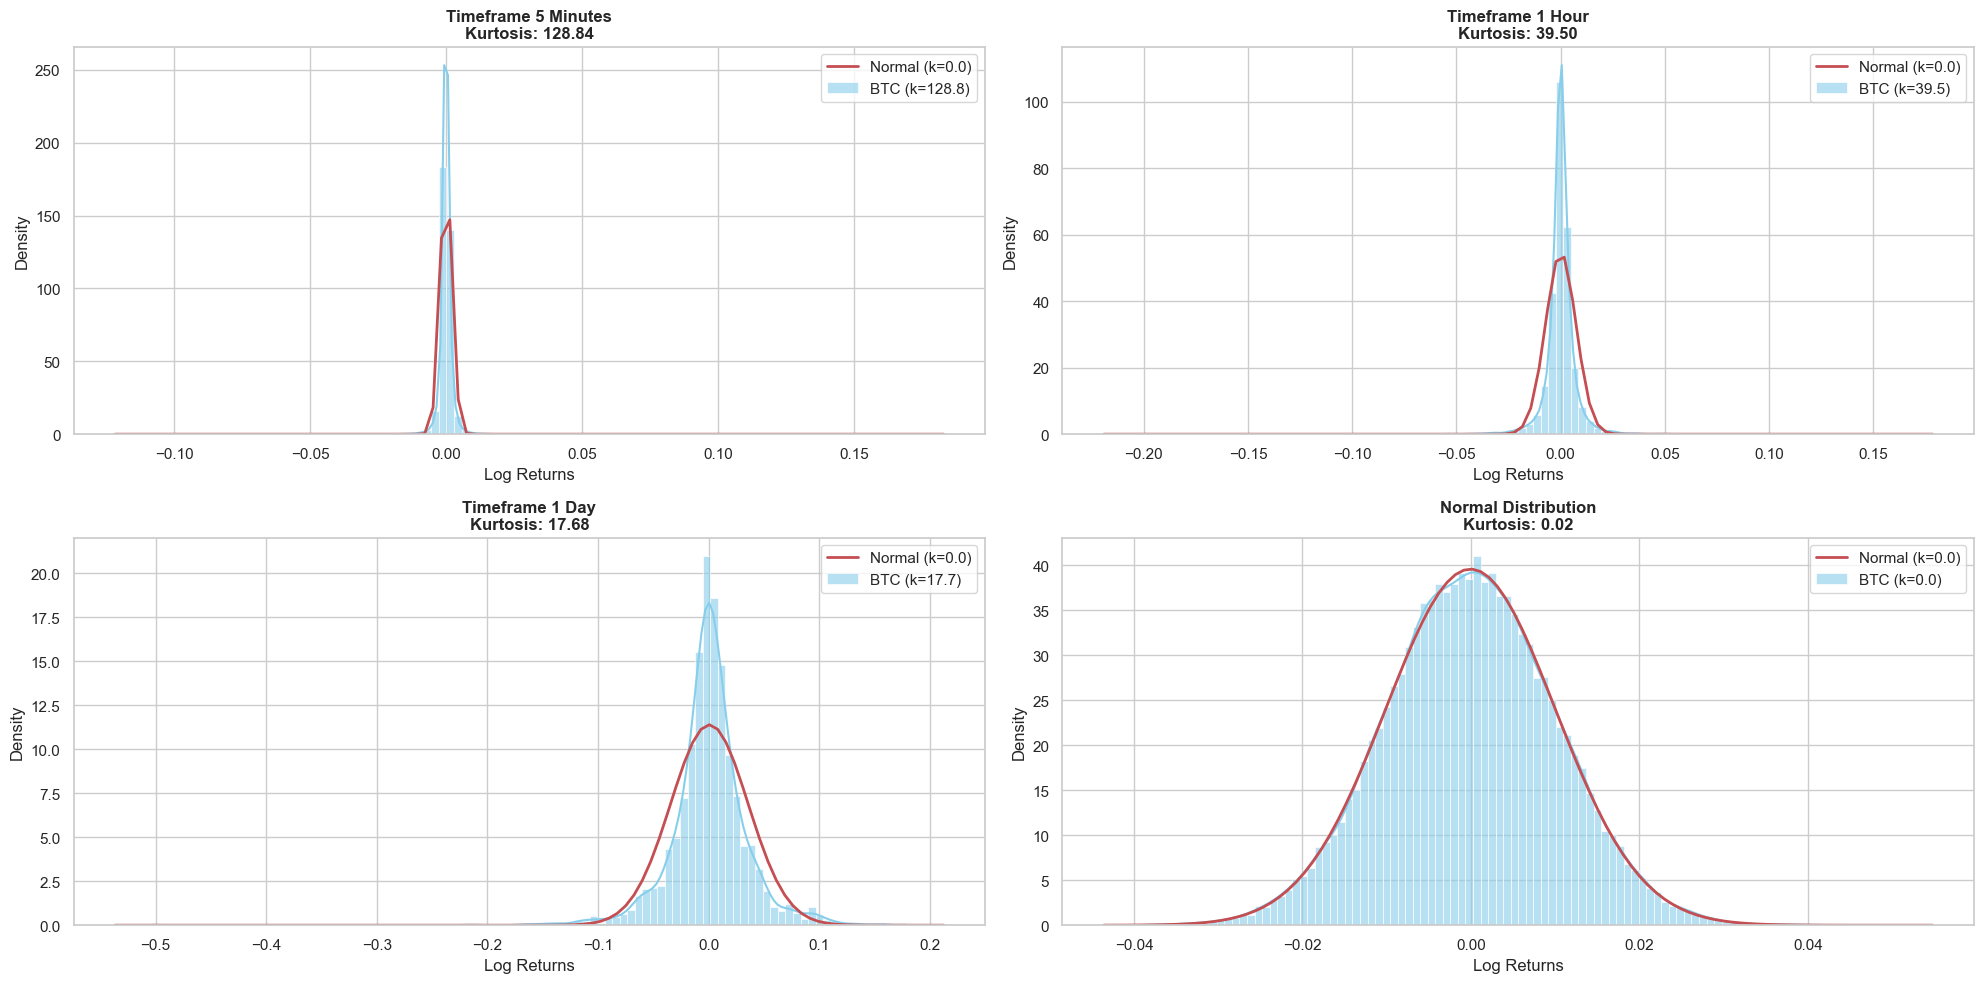

In [32]:
# configuration for multiple plots
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Generating normal distribution dataset
datos = np.random.normal(loc=0, scale=0.01, size=60000)
initial_price = 10000
df_normal = initial_price * np.exp(np.cumsum(datos))
df_normal = pd.DataFrame(df_normal, columns=['Close'])

# List of datasets and their names
datasets = [
    (df_5m, "Timeframe 5 Minutes"),
    (df_1h, "Timeframe 1 Hour"),
    (df_1d, "Timeframe 1 Day"),
    (df_normal, "Normal Distribution")
]

# Loop through datasets and plot
for ax, (df, name) in zip(axes.flatten(), datasets):
    
    # Logaritmic Returns Calculation
    data = df.copy()
    data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
    data.dropna(inplace=True)
    
    # Kurtosis Calculation
    k_val = stats.kurtosis(data['log_return'], fisher=True)
    
    # Logaritmic returns Histogram
    sns.histplot(data['log_return'], bins=100, kde=True, stat="density", 
                 color='skyblue', alpha=0.6, label=f"BTC (k={k_val:.1f})", ax=ax)
    
    # Normal distribution line
    mu, std = stats.norm.fit(data['log_return'])
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)

    # Plot normal distribution
    ax.plot(x, p, 'r', linewidth=2, label="Normal (k=0.0)")
    ax.set_title(f'{name}\nKurtosis: {k_val:.2f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Log Returns')
    ax.set_ylabel('Density')
    ax.legend()
plt.tight_layout()
plt.show()

As we can appreciate, the three timeframes' distributions are leptokurtic. However, the higher the timeframe the lower the kurtosis. This is a crucial factor to take into account when deciding which model could suit best. Models that work better with a normal distribution (for instance, KNN or linear regression) will have a  outperform in high timeframes. On the other hand, the best model choice in a low timeframe are the decision trees.

In order to see clearer the outliers we are creating some boxplots.

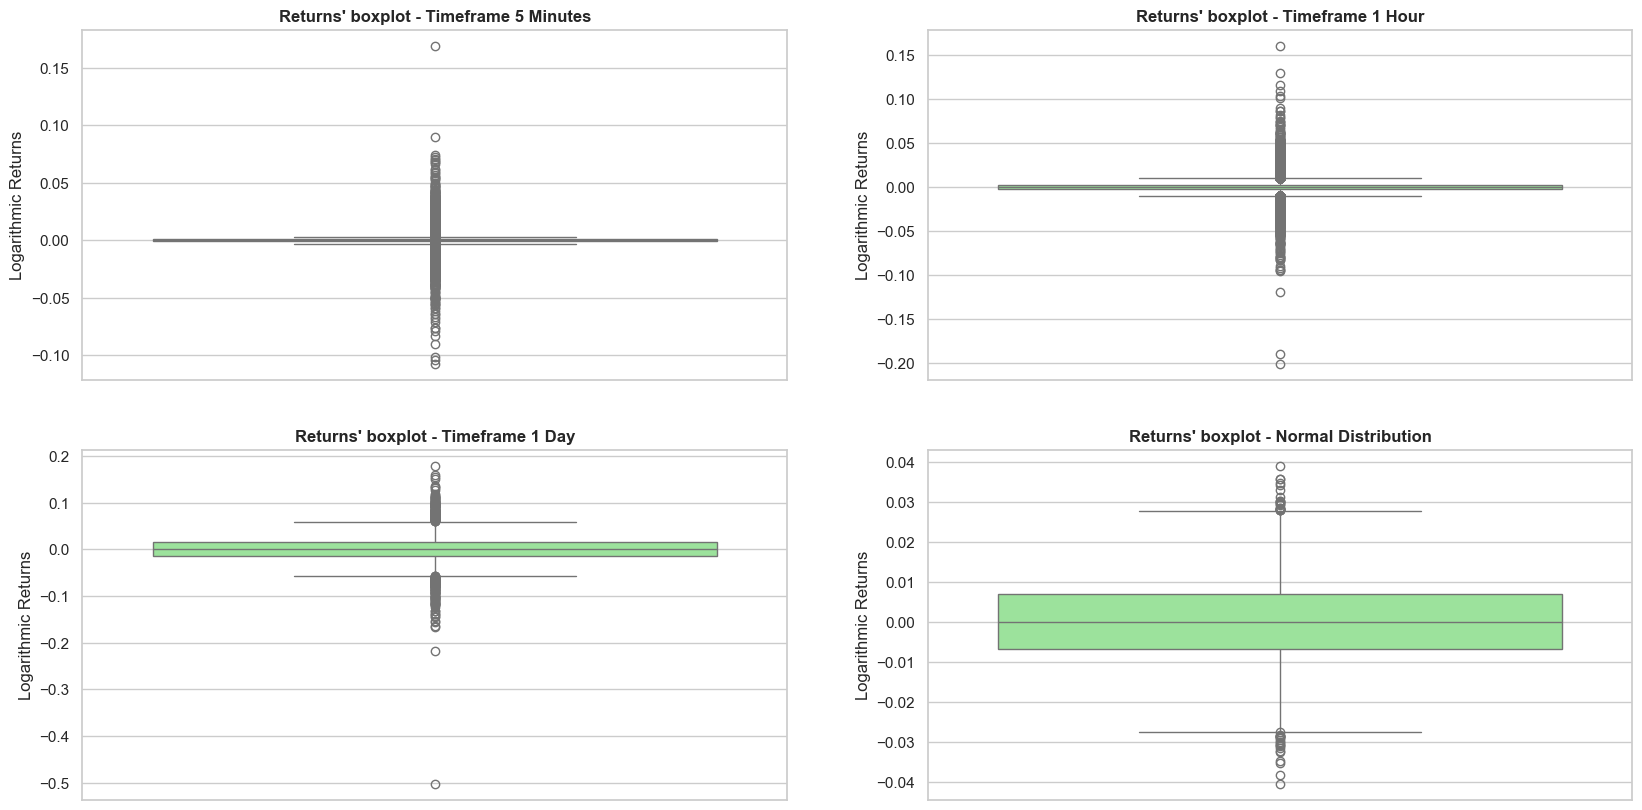

In [33]:
# Preparing data for BoxPlots
datos = np.random.normal(loc=0, scale=0.01, size=10000)
initial_price = 10000
df_normal = initial_price * np.exp(np.cumsum(datos))
df_normal = pd.DataFrame(df_normal, columns=['Close'])
datasets = [
    (df_5m, "Timeframe 5 Minutes"),
    (df_1h, "Timeframe 1 Hour"),
    (df_1d, "Timeframe 1 Day"),
    (df_normal, "Normal Distribution")
]
# Plotting BoxPlots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for ax, (df, name) in zip(axes.flatten(), datasets):
    data = df.copy()
    data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
    data.dropna(inplace=True)
    
    sns.boxplot(y=data['log_return'], ax=ax, color='lightgreen')
    ax.set_title(f"Returns' boxplot - {name}", fontsize=12, fontweight='bold')
    ax.set_ylabel('Logarithmic Returns')

As it was expected, the higher the timeframe the wider the boxplots' body. Eventhough 1 day timeframe's boxplot has the wider box, it is far away from the normal distribution boxplot.

Now, we are counting the outliers of each timeframe.

In [34]:
# Counting outliers function
def count_outliers(df, name):
    # Logaritmic returns
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    data = df['log_return'].dropna()
    # Selecting the outliers
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    body = q3 - q1
    lower_bound = q1 - 1.5 * body
    upper_bound = q3 + 1.5 * body
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    # Counting outliers
    num_outliers = len(outliers)
    num_data = len(data)
    percentage = (num_outliers / num_data) * 100
    max_outlier = np.exp(max(outliers)) - 1
    min_outlier = np.exp(min(outliers)) - 1
    
    # Printing the results
    print(f"OUTLIERS RESULTS OF {name}")
    print(f"№ The number of outliers is: {num_outliers}.")
    print(f"📊 The percentage of outliers is: {percentage:.2f}%.")
    print(f"📈 The highest value is: +{max_outlier:.2f}%. ")
    print(f"📉 The lowest value is: {min_outlier:.2f}%.")
    print('-'*50)

    return outliers

# Counting outliers for each dataset
outliers_5m = count_outliers(df_5m, "BTC/USDT 5 minutes")
outliers_1h = count_outliers(df_1h, "BTC/USDT 1 hour")
outliers_1d = count_outliers(df_1d, "BTC/USDT 1 day")
outliers_normal = count_outliers(df_normal, "Normal Distribution")

OUTLIERS RESULTS OF BTC/USDT 5 minutes
№ The number of outliers is: 70808.
📊 The percentage of outliers is: 8.54%.
📈 The highest value is: +0.18%. 
📉 The lowest value is: -0.10%.
--------------------------------------------------
OUTLIERS RESULTS OF BTC/USDT 1 hour
№ The number of outliers is: 6683.
📊 The percentage of outliers is: 9.67%.
📈 The highest value is: +0.17%. 
📉 The lowest value is: -0.18%.
--------------------------------------------------
OUTLIERS RESULTS OF BTC/USDT 1 day
№ The number of outliers is: 251.
📊 The percentage of outliers is: 8.70%.
📈 The highest value is: +0.20%. 
📉 The lowest value is: -0.40%.
--------------------------------------------------
OUTLIERS RESULTS OF Normal Distribution
№ The number of outliers is: 44.
📊 The percentage of outliers is: 0.44%.
📈 The highest value is: +0.04%. 
📉 The lowest value is: -0.04%.
--------------------------------------------------


As it was expected, bitcoins data has a lot more outliers than the synthetic data. Curiously, the three timeframes' datasets have the same amount of outliers, which strange after seing the boxplots. It is obvius that the higher the timeframe the higher the max/min outlier value is.

### Distribution conclusion
The leptokurtic distributions tells us that the models that are optimal with normal distributions may not be the best ones for this proyect.
The vast amount of outliers says that the model that is going to be trained must be trained with them.

## Volativity
Analizing volativity is a crucial factor in this EDA. 

## Seasonality
An essential characteristic to analize is seasonality. Depending on seasonality a model would suit or not.

First we are plotting an ACF (autocorrelative function graph). 

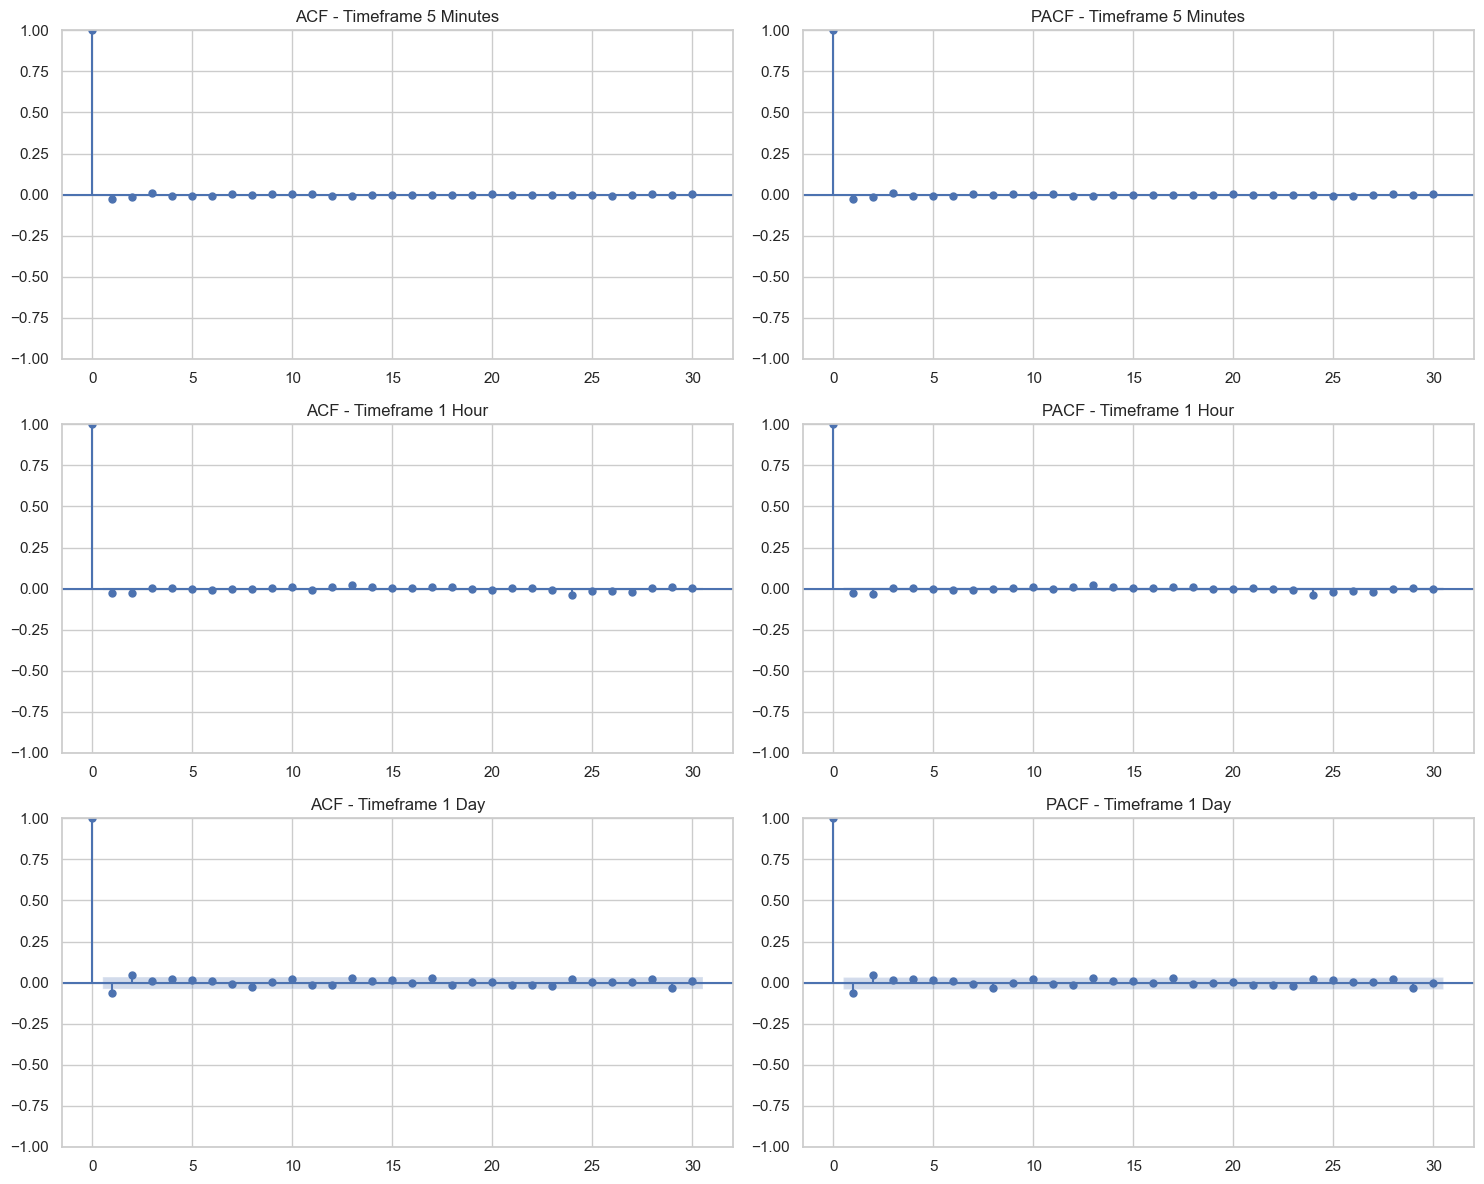

In [35]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Logarithmic returns for each timeframe
df_1d['log_return'] = np.log(df_1d['Close'] / df_1d['Close'].shift(1))
df_1d.dropna(inplace=True)
df_1h['log_return'] = np.log(df_1h['Close'] / df_1h['Close'].shift(1))
df_1h.dropna(inplace=True)  
df_5m['log_return'] = np.log(df_5m['Close'] / df_5m['Close'].shift(1))
df_5m.dropna(inplace=True)

# Preparing the datasets
datasets = [
    (df_5m, "Timeframe 5 Minutes"),
    (df_1h, "Timeframe 1 Hour"),
    (df_1d, "Timeframe 1 Day")
]

# Prepararing the plots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Plotting ACF and PACF graphs
for ax, (df, name) in zip(axes, datasets):
    plot_acf(df['log_return'], ax=ax[0], lags=30, title=f'ACF - {name}')
    plot_pacf(df['log_return'], ax=ax[1], lags=30, title=f'PACF - {name}')
plt.tight_layout()
plt.show()

Every graph clearly show how the 2 last candles are the ones that have the higher impact in the current candle.
Now we will repeat the process but with squared returns.

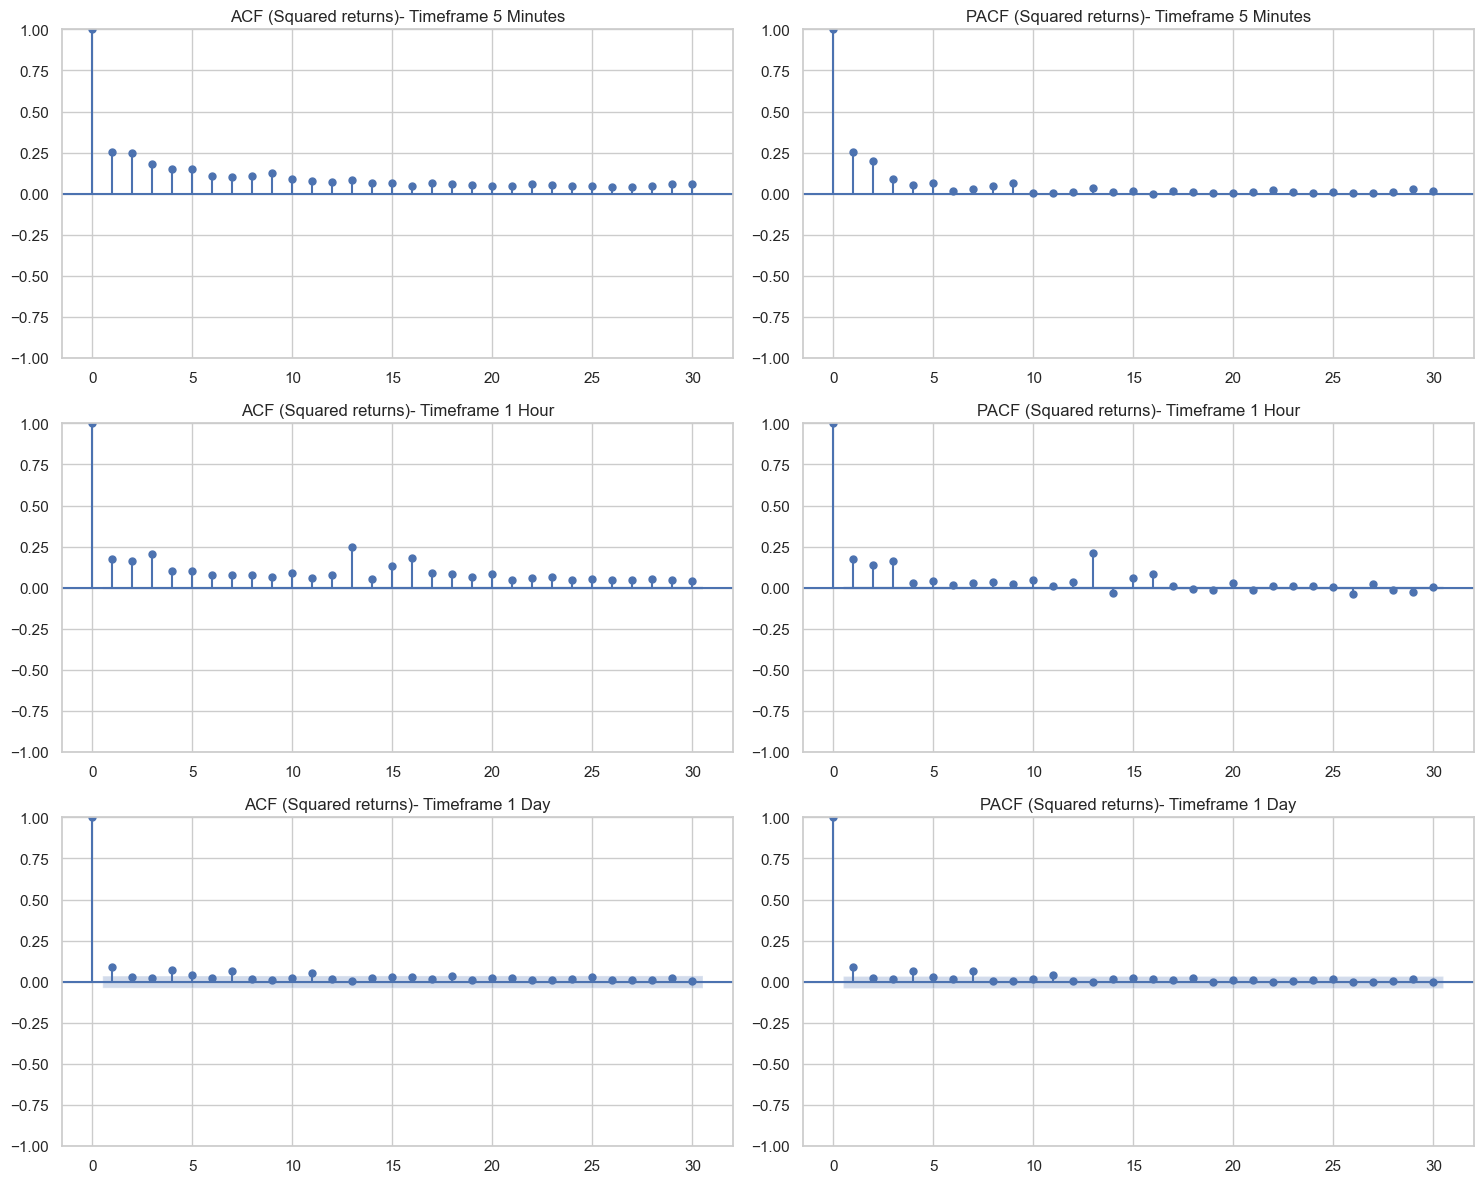

In [36]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Squared logarithmic returns for each timeframe
df_1d['log_return_squared'] = df_1d['log_return'] ** 2
df_1d.dropna(inplace=True)
df_1h['log_return_squared'] = df_1h['log_return'] ** 2
df_1h.dropna(inplace=True)  
df_5m['log_return_squared'] = df_5m['log_return'] ** 2
df_5m.dropna(inplace=True)

# Preparing the datasets
datasets = [
    (df_5m, "Timeframe 5 Minutes"),
    (df_1h, "Timeframe 1 Hour"),
    (df_1d, "Timeframe 1 Day")
]

# Prepararing the plots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Plotting ACF and PACF graphs
for ax, (df, name) in zip(axes, datasets):
    plot_acf(df['log_return_squared'], ax=ax[0], lags=30, title=f'ACF (Squared returns)- {name}')
    plot_pacf(df['log_return_squared'], ax=ax[1], lags=30, title=f'PACF (Squared returns)- {name}')
plt.tight_layout()
plt.show()

As we can observe, after strong movements, it is probable to see another one. This metric is particularly useful for the risk management.


In order to see analize the stationarity, we are calculating the ADF test (Augmented Dickey-Fuller test).

**ADF test** This test will determine if the series is stationary or not. If the ADF statistic is less than -3.43, then the series is stationary, an the more negative the number is, the more stationary it will be. The p-value tell us the probability that the result is due to chance, assuming the null hypothesis is true.

In [37]:
# ADF Test
from statsmodels.tsa.stattools import adfuller
def adf_test(dframe, name):
    df = dframe.copy()
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    data = df['log_return'].dropna()
    result = adfuller(data)
    print(f"ADF Test Results for {name}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f'Critical Value: -3.43')
    if result[1] < 0.05:
        print("The series is stationary (reject H0)")
    else:
        print("The series is non-stationary (fail to reject H0)")
    print('-'*50)
adf_test(df_1d, "BTC/USDT 1 day")
# As this test is computationally expensive, we will use only the last year of data for the lower timeframes
adf_test(df_1h.tail(9000), "BTC/USDT 1 hour (Last year)")
adf_test(df_5m.tail(9000*20), "BTC/USDT 5 minutes (Last year)")

ADF Test Results for BTC/USDT 1 day:
ADF Statistic: -37.474923302625676
p-value: 0.0
Critical Value: -3.43
The series is stationary (reject H0)
--------------------------------------------------
ADF Test Results for BTC/USDT 1 hour (Last year):
ADF Statistic: -23.031013187334107
p-value: 0.0
Critical Value: -3.43
The series is stationary (reject H0)
--------------------------------------------------
ADF Test Results for BTC/USDT 5 minutes (Last year):
ADF Statistic: -52.76838654339927
p-value: 0.0
Critical Value: -3.43
The series is stationary (reject H0)
--------------------------------------------------


## Heteroskedasticitiy
Accounting for heteroskedasticity is crucial for accurate risk management. We are seeing if the volatility changes over the time.

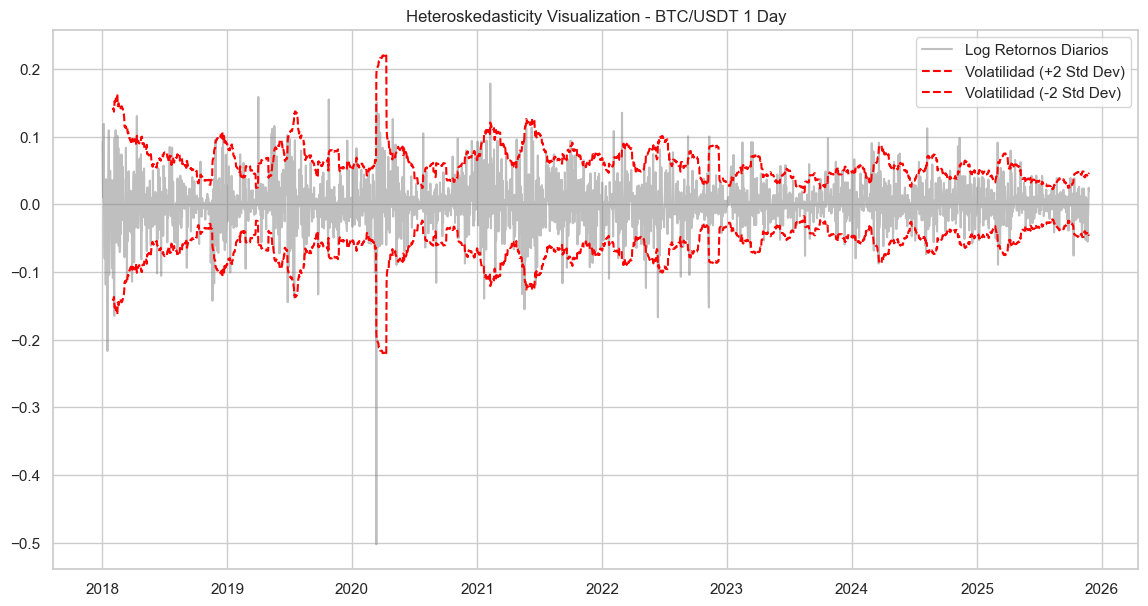

In [38]:
# 30 day winsow
window_size = 30 

# Moving average and standard deviation calculation
rolling_mean = df_1d['log_return'].rolling(window=window_size).mean()
rolling_std = df_1d['log_return'].rolling(window=window_size).std()

# Visualization
plt.figure(figsize=(14, 7))
plt.plot(df_1d['log_return'], label='Log Retornos Diarios', alpha=0.5, color='grey')
plt.plot(rolling_std * 2, label='Volatilidad (+2 Std Dev)', color='red', linestyle='--')
plt.plot(rolling_std * -2, label='Volatilidad (-2 Std Dev)', color='red', linestyle='--')
plt.title('Heteroskedasticity Visualization - BTC/USDT 1 Day')
plt.legend()
plt.show()

As it is shown in the graph, volatility does not remain constant over the time. Therefore, we assume **heteroskedasticity**.

Now, let's take a deeper insight in seasonality. We are using statsmodel library in order to visualize different timeperiod seasonalities.

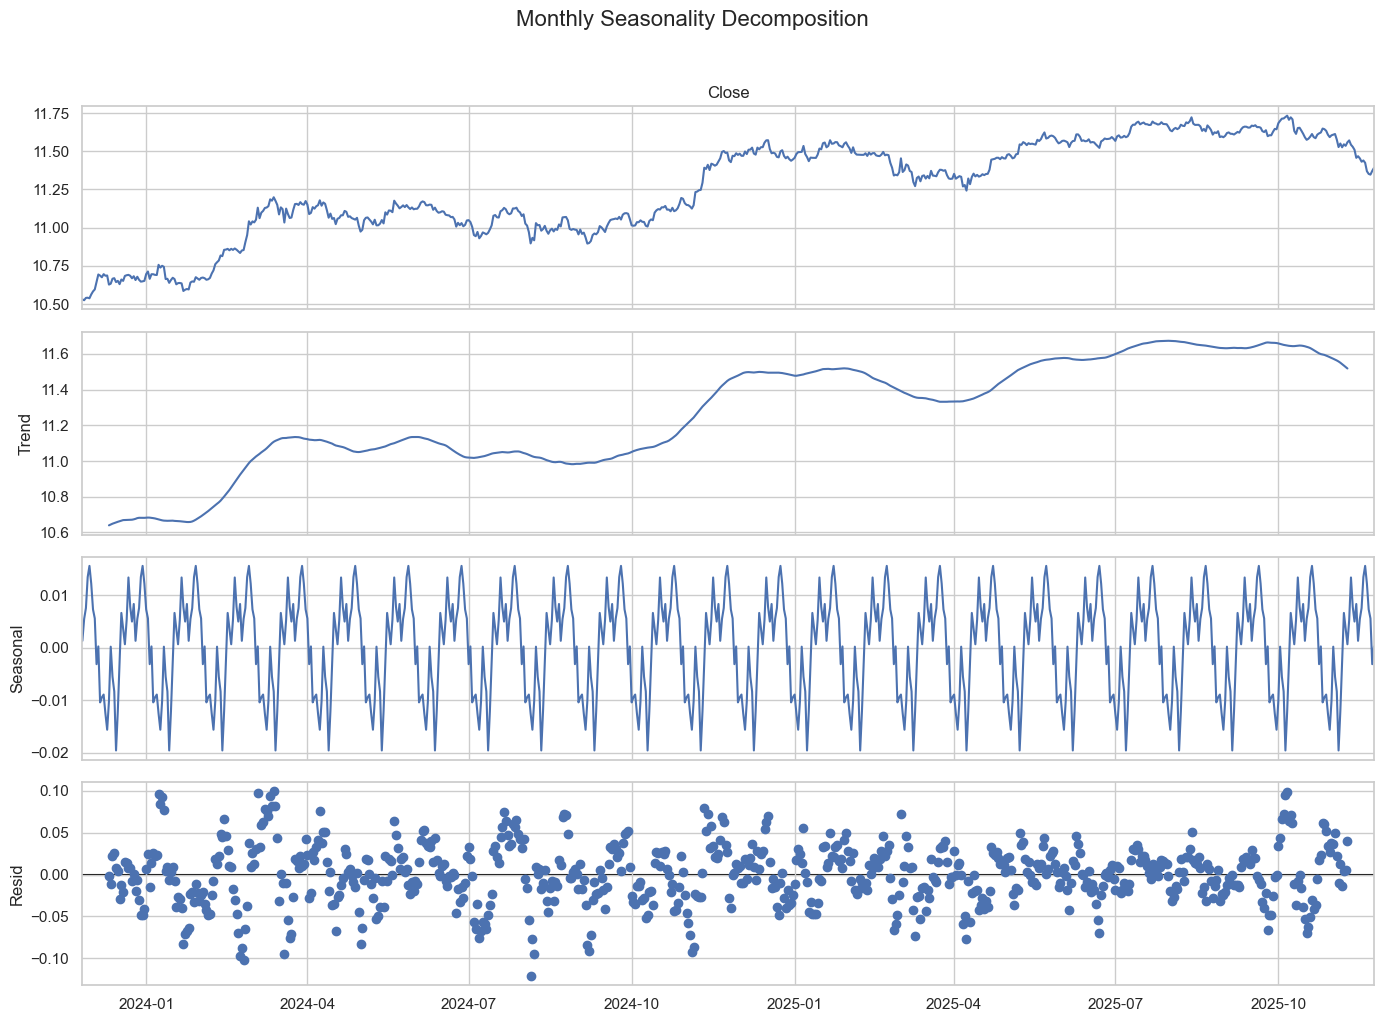

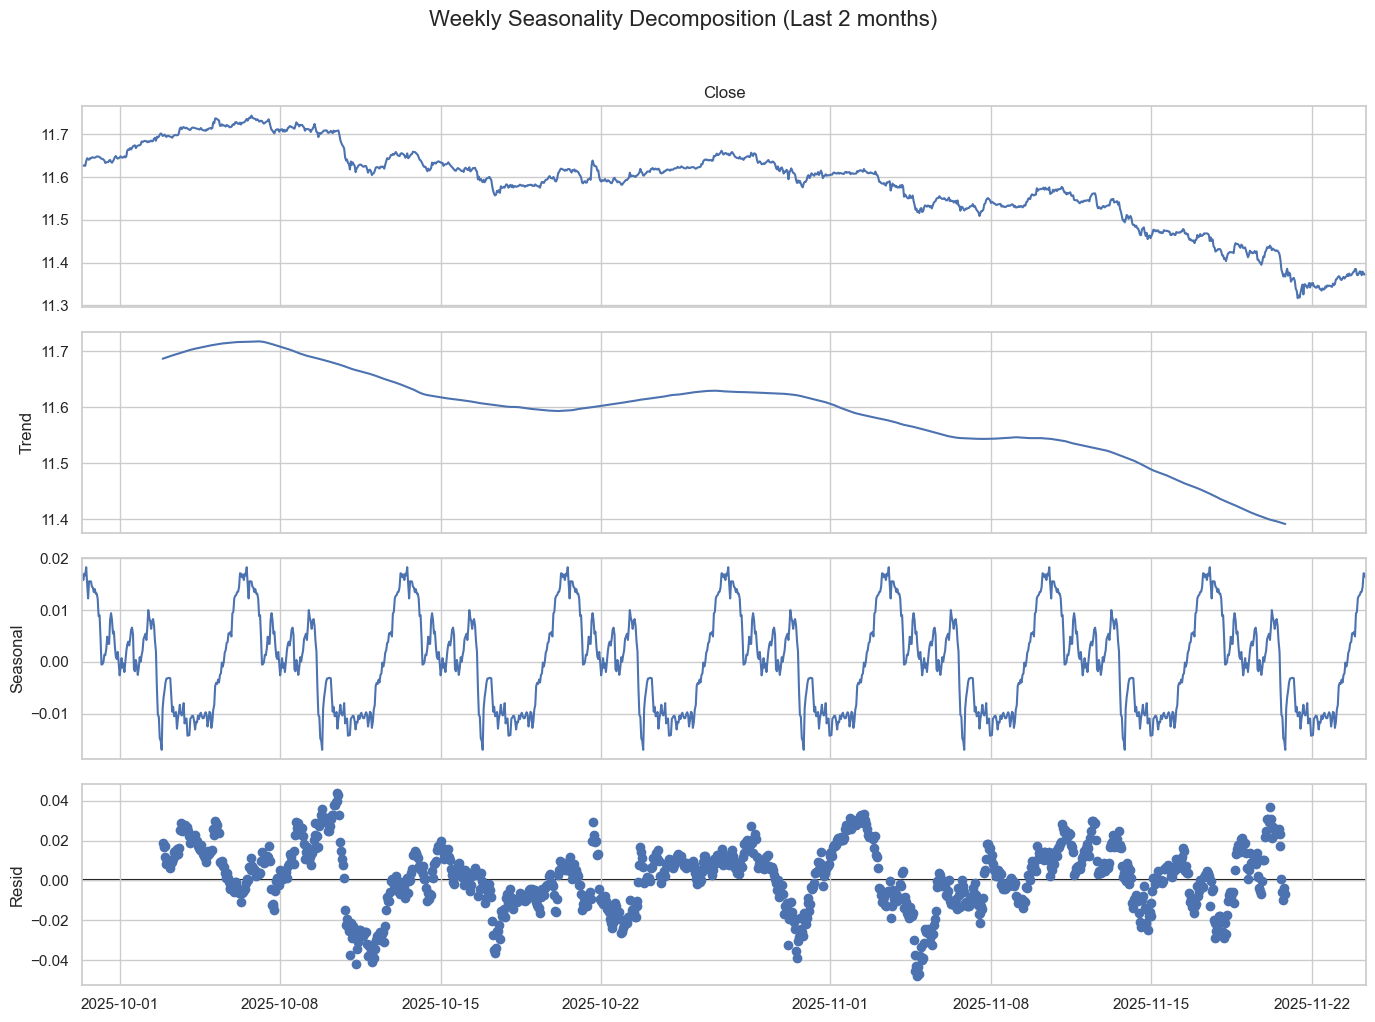

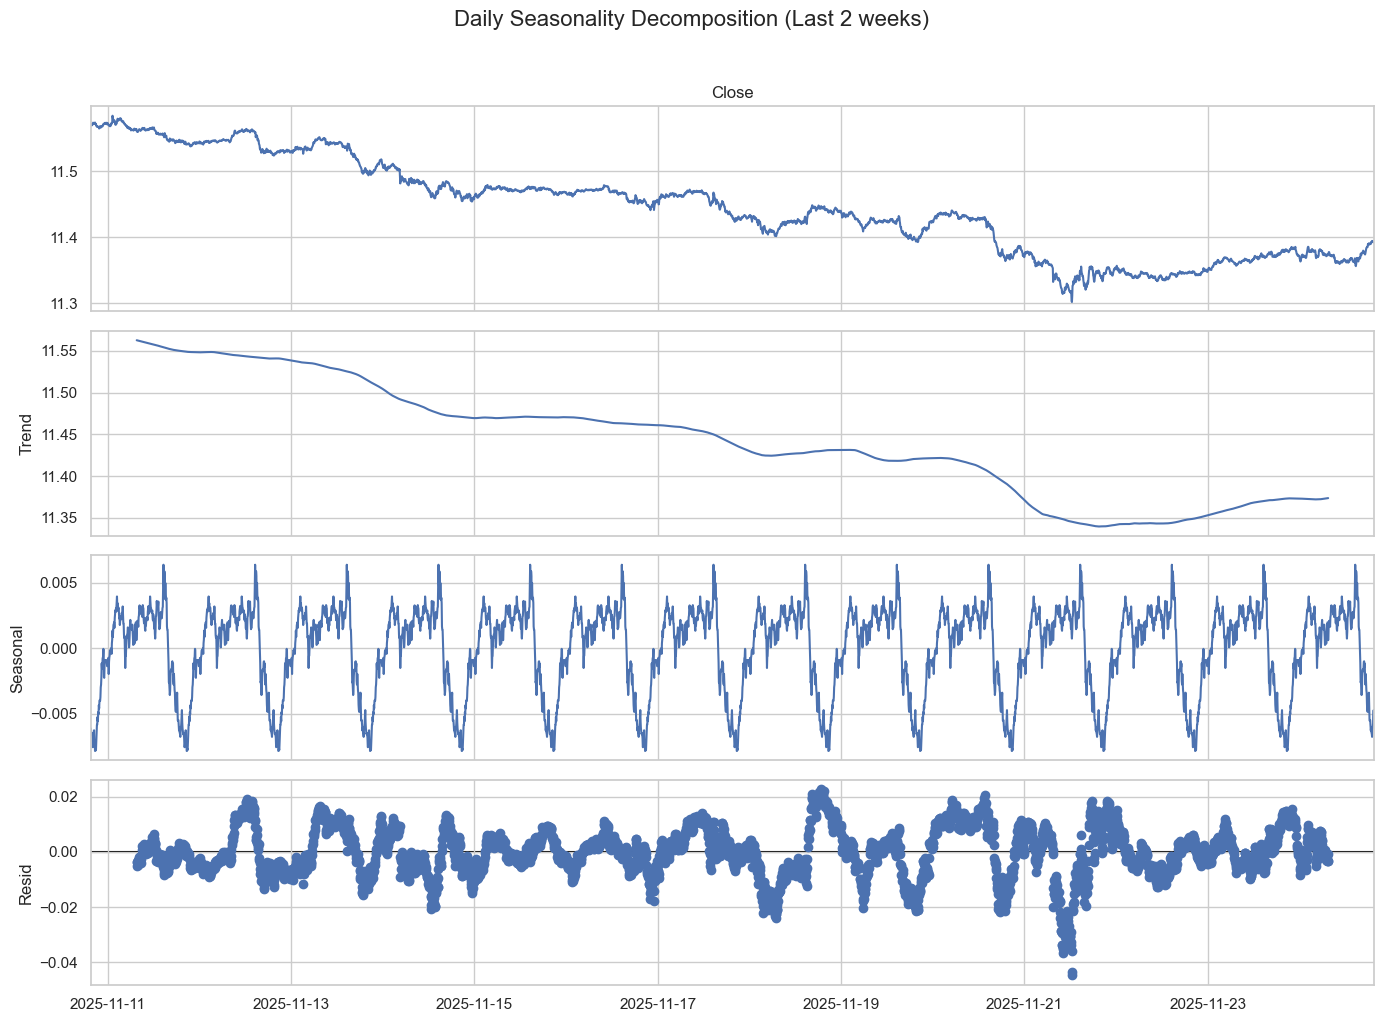

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Monthly seasonality decomposition
log_price = np.log(df_1d['Close'].tail(365*2))
decomposition = seasonal_decompose(log_price, model='additive', period=30)
# Visualization
fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Monthly Seasonality Decomposition', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Weekly seasonality decomposition (Last 1 months)
log_price = np.log(df_1h['Close'].tail(8*7*24))  
decomposition = seasonal_decompose(log_price, model='additive', period=24*7)
# Visualization
fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Weekly Seasonality Decomposition (Last 2 months)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()  

# Daily seasonality decomposition (Last 100 days)
log_price = np.log(df_5m['Close'].tail(12*24*14))  
decomposition = seasonal_decompose(log_price, model='additive', period=24*12)
# Visualization
fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Daily Seasonality Decomposition (Last 2 weeks)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

📊 Final Conclusions on Time Series Decomposition
Based on the multi-timeframe analysis (Monthly, Weekly, and Daily decompositions), we can derive the following insights regarding the Bitcoin (BTC/USDT) price dynamics:

1. Monthly Seasonality

Long-Term Dynamics: The Monthly Decomposition reveals that the Trend component is the dominant force driving prices in the long run.

Negligible Monthly Cycle: The seasonal component at the monthly level exhibits a very low amplitude (≈1%), suggesting that there is no strong calendar effect in Bitcoin. Long-term strategies should focus on trend-following rather than calendar arbitrage.

2. Weekly Seasonality

Liquidity Cycles: The Weekly Decomposition shows a clear and repetitive seasonal pattern with regular dips.

Interpretation: This confirms the structural difference between weekdays and weekends. This seasonality is statistically significant and suggests that price action during off-hours requires careful validation.

3. Predictable Intraday Microstructure

Market Sessions: The Daily Decomposition reveals distinct peaks in activity corresponding to global market sessions (Asian, European/London, and US/NY opens).

Implication: Intraday volatility is not random; it follows a predictable time-of-day schedule. Algorithms should adjust their risk parameters based on the time of day.

4. Confirmation of Conditional Heteroskedasticity

Volatility Clustering: Across all timeframes, the Residuals do not look like Gaussian White Noise. Instead, they exhibit "clustering"—periods of low variance followed by explosive bursts of high variance.

Mathematical Implication: The assumption of constant variance is violated. Linear models (like simple ARIMA) will fail to capture the risk dynamics. This empirically validates the need for Volatility Models (ARCH/GARCH) to correctly estimate the standard deviation for risk management.